## NCAA Tournament Predictions
- Toy Model --> Go by ESPN power rankings scraped from https://www.espn.com/mens-college-basketball/bpi
1. Webscrape using Beautiful Soup and/or Pandas
2. Generate Predictions all based on power rankings
3. Create valid submission file for men and women
4. First iteration --> Generate my own rankings?

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as ml
import plotly as py
import seaborn as sns
import requests
import re

pd.set_option('display.max_columns', 50)

In [2]:
# Get teams to start merging with features for model
PATH = '/kaggle/input/warmup-round-march-machine-learning-mania-2023/'
mteams = pd.read_csv('/kaggle/input/warmup-round-march-machine-learning-mania-2023/MTeams.csv')
wteams = pd.read_csv('/kaggle/input/warmup-round-march-machine-learning-mania-2023/WTeams.csv')

mgames = pd.read_csv(PATH+'MRegularSeasonCompactResults.csv')
wgames = pd.read_csv('/kaggle/input/warmup-round-march-machine-learning-mania-2023/WRegularSeasonCompactResults.csv')

In [3]:
massey_rankings = pd.read_csv('/kaggle/input/warmup-round-march-machine-learning-mania-2023/MMasseyOrdinals.csv')
last_rank = massey_rankings[massey_rankings['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True)
last_rank

,Season,SystemName,TeamID,OrdinalRank
0,2003,AP,1112,2
1,2003,AP,1163,23
2,2003,AP,1166,15
3,2003,AP,1173,16
4,2003,AP,1181,7
...,...,...,...,...
332132,2022,WOL,1468,155
332133,2022,WOL,1469,251
332134,2022,WOL,1470,225
332135,2022,WOL,1471,256


In [4]:
# Begin our actual putting together of data with the tourney results
mtourneys = pd.read_csv('/kaggle/input/warmup-round-march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv')
mtourneys.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
mtourneys 

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38
...,...,...,...,...,...,...
2379,2022,146,1242,76,1274,50
2380,2022,146,1314,69,1389,49
2381,2022,152,1242,81,1437,65
2382,2022,152,1314,81,1181,77


In [5]:
mseeds = pd.read_csv(PATH + 'MNCAATourneySeeds.csv')
mseeds['Seed'] = mseeds.Seed.apply(lambda seed: re.sub("[^0-9]", "", seed)).astype(int)
mseeds

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374
...,...,...,...
2417,2022,13,1151
2418,2022,14,1255
2419,2022,15,1174
2420,2022,16,1136


In [6]:
kenpom = pd.read_csv('/kaggle/input/kenpom-clean/kenpom-data.csv')
kenpom = kenpom.drop(kenpom.columns[0],axis=1)
kenpom.Rk = kenpom.Rk.astype('int')
kenpom.Team = kenpom.Team.astype('str')

The data table above contains info about the results of games played on a given day. It reports the winner, loser, and stats about both. Take Duke. We want an entry for all of their games where they are a loser and all of their games where they are a winner. We also want all of UNC's games where they are a winner or a loser. All possible winning/losing matchups for every team should be present as separate entries so that we can make individual predictions for a given team against any other given team. This will create a LOT of seemingly redundant data, but its likely the easiest way to make forecasts.

Right now, we've got all of the matchups, the ones where duke is a winner and those where duke is a winner. Let's make a copy where we have all of duke's wins and all of duke's losses.

In [7]:
'''
# Create dictionary of column renamings to make a symmetrical data set of winners/losers
# Change all wins to "A" and all loss features to "B"
win_rename = {
    'WTeamID': 'TeamIDA', 'WScore':'ScoreA', 'LTeamID':'TeamIDB', 'LScore':'ScoreB','SeedW':'SeedA',
    'SeedL':'SeedB','NumWinsW':'NumWinsA', 'NumLossesW':'NumLossesA', 'AvgWinMarginW':'AvgWinMarginA',
    'AvgLossMarginW':'AvgLossMarginA', 'WinPctW': 'WinPctA','AvgScoreMarginW':'AvgScoreMarginA',
    'NumWinsL':'NumWinsB', 'NumLossesL':'NumLossesB', 'AvgWinMarginL':'AvgWinMarginB',
    'AvgLossMarginL':'AvgLossMarginB', 'WinPctL':'WinPctB', 'AvgScoreMarginL':'AvgScoreMarginB',
    'ComputerRankW':'ComputerRankA','ComputerRankL':'ComputerRankB'
}

# Make another dict where we change all win features to "B" and loss features to "A"
loss_rename = {
    'WTeamID': 'TeamIDB', 'WScore':'ScoreB', 'LTeamID':'TeamIDA', 'LScore':'ScoreA','SeedW':'SeedB',
    'SeedL':'SeedA','NumWinsW':'NumWinsB', 'NumLossesW':'NumLossesB', 'AvgWinMarginW':'AvgWinMarginB',
    'AvgLossMarginW':'AvgLossMarginB', 'WinPctW': 'WinPctB','AvgScoreMarginW':'AvgScoreMarginB',
    'NumWinsL':'NumWinsA', 'NumLossesL':'NumLossesA', 'AvgWinMarginL':'AvgWinMarginA',
    'AvgLossMarginL':'AvgLossMarginA', 'WinPctL':'WinPctA', 'AvgScoreMarginL':'AvgScoreMarginA',
    'ComputerRankW':'ComputerRankB','ComputerRankL':'ComputerRankA'
}
# Create new df's with these column names
win_data = data.copy().rename(columns=win_rename)
loss_data = data.copy().rename(columns=loss_rename)

# Merge our new data frames to create a symmetric win/loss one
symmetric_data = pd.concat([win_data,loss_data], axis=0, sort=False)
symmetric_data
'''

'\n# Create dictionary of column renamings to make a symmetrical data set of winners/losers\n# Change all wins to "A" and all loss features to "B"\nwin_rename = {\n    \'WTeamID\': \'TeamIDA\', \'WScore\':\'ScoreA\', \'LTeamID\':\'TeamIDB\', \'LScore\':\'ScoreB\',\'SeedW\':\'SeedA\',\n    \'SeedL\':\'SeedB\',\'NumWinsW\':\'NumWinsA\', \'NumLossesW\':\'NumLossesA\', \'AvgWinMarginW\':\'AvgWinMarginA\',\n    \'AvgLossMarginW\':\'AvgLossMarginA\', \'WinPctW\': \'WinPctA\',\'AvgScoreMarginW\':\'AvgScoreMarginA\',\n    \'NumWinsL\':\'NumWinsB\', \'NumLossesL\':\'NumLossesB\', \'AvgWinMarginL\':\'AvgWinMarginB\',\n    \'AvgLossMarginL\':\'AvgLossMarginB\', \'WinPctL\':\'WinPctB\', \'AvgScoreMarginL\':\'AvgScoreMarginB\',\n    \'ComputerRankW\':\'ComputerRankA\',\'ComputerRankL\':\'ComputerRankB\'\n}\n\n# Make another dict where we change all win features to "B" and loss features to "A"\nloss_rename = {\n    \'WTeamID\': \'TeamIDB\', \'WScore\':\'ScoreB\', \'LTeamID\':\'TeamIDA\', \'LScore\':

Next, create some differences such as difference in seed or win pct to see if that's the key metric not the individual values.

In [8]:
'''symmetric_data['SeedDiff'] = symmetric_data['SeedA'] - symmetric_data['SeedB']
symmetric_data['WinPctDiff'] = symmetric_data['WinPctA'] - symmetric_data['WinPctB']
symmetric_data['AvgScoreMarginDiff'] = symmetric_data['AvgScoreMarginA'] - symmetric_data['AvgScoreMarginB']
symmetric_data['ComputerRankDiff'] = symmetric_data['ComputerRankA'] - symmetric_data['ComputerRankB']
symmetric_data
'''

"symmetric_data['SeedDiff'] = symmetric_data['SeedA'] - symmetric_data['SeedB']\nsymmetric_data['WinPctDiff'] = symmetric_data['WinPctA'] - symmetric_data['WinPctB']\nsymmetric_data['AvgScoreMarginDiff'] = symmetric_data['AvgScoreMarginA'] - symmetric_data['AvgScoreMarginB']\nsymmetric_data['ComputerRankDiff'] = symmetric_data['ComputerRankA'] - symmetric_data['ComputerRankB']\nsymmetric_data\n"

Below we build a pre processing fucntion to do everything we just did to the data (later we'll incorporate KenPom ratings) so that we can easily apply it to the test data.

In [9]:
# Create preprocessing pipeline that accepts already imported dataframes
def preprocess_data(teams, tourneys, games, seeds, ranks):
    return_df = pd.DataFrame()
    
    losses = games.groupby(['Season', 'LTeamID']).count()
    wins = games.groupby(['Season', 'WTeamID']).count()
    
    games['WinMargin'] = abs(games['WScore'] - games['LScore'])
    games['LossMargin'] = abs(games['LScore']-games['WScore'])

    num_loss = losses.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'NumLosses', 'LTeamID': 'TeamID'}).fillna(0)
    num_wins = wins.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'NumWins', 'WTeamID': 'TeamID'}).fillna(0)

    win_margin = games.groupby(['Season', 'WTeamID']).mean().reset_index().rename(columns={'WTeamID': 'TeamID', 'WinMargin':'AvgWinMargin'})
    win_margin = win_margin[['Season', 'TeamID', 'AvgWinMargin']].fillna(0)

    loss_margin = games.groupby(['Season', 'LTeamID']).mean().reset_index().rename(columns={'LTeamID': 'TeamID', 'LossMargin':'AvgLossMargin'})
    loss_margin = loss_margin[['Season', 'TeamID', 'AvgLossMargin']].fillna(0)
    
    winners_and_losers = pd.merge(num_wins, num_loss, left_on=['Season','TeamID'], right_on=['Season','TeamID'])
    winners_and_losers = pd.merge(winners_and_losers, win_margin, left_on=['Season','TeamID'],right_on=['Season','TeamID'])
    winners_and_losers = pd.merge(winners_and_losers, loss_margin, left_on=['Season','TeamID'],right_on=['Season','TeamID'])

    winners_and_losers['WinPct'] = winners_and_losers['NumWins']/(winners_and_losers['NumWins'] + winners_and_losers['NumLosses'])
    winners_and_losers['AvgScoreMargin'] = (
    (winners_and_losers['NumWins'] * winners_and_losers['AvgWinMargin'] - winners_and_losers['NumLosses'] * winners_and_losers['AvgLossMargin'])
    / (winners_and_losers['NumWins'] + winners_and_losers['NumLosses'])
    )
    
    data = pd.merge(
        tourneys, seeds, how='left', 
        left_on=['Season','WTeamID'], 
        right_on=['Season','TeamID']
    ).drop(['TeamID'],axis=1).rename(columns={'Seed': 'SeedW'})

    data = pd.merge(
        data, seeds, how='left', 
        left_on=['Season','LTeamID'], 
        right_on=['Season','TeamID']
    ).drop(['TeamID'],axis=1).rename(columns={'Seed': 'SeedL'})

    data = data[data['Season']>=2003].reset_index(drop=True)
    
    data = pd.merge(
        data, winners_and_losers, how = 'left', 
        left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']
    ).rename(columns={'NumWins':'NumWinsW',
                      'NumLosses': 'NumLossesW',
                      'AvgWinMargin': 'AvgWinMarginW',
                      'AvgLossMargin': 'AvgLossMarginW',
                      'WinPct': 'WinPctW',
                      'AvgScoreMargin':'AvgScoreMarginW'
    }).drop(columns='TeamID', axis=1)

    # Now merge data DF with loser season info marking everything with an L for loser columns
    data = pd.merge(
        data, winners_and_losers, how='left',
        left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']
    ).rename(columns={'NumWins':'NumWinsL',
                      'NumLosses': 'NumLossesL',
                      'AvgWinMargin': 'AvgWinMarginL',
                      'AvgLossMargin': 'AvgLossMarginL',
                      'WinPct': 'WinPctL',
                      'AvgScoreMargin':'AvgScoreMarginL'
    }).drop(columns='TeamID', axis=1)
    
    avg_rank = ranks.groupby(by=['Season','TeamID']).mean().reset_index()

    # First merge with rank of winners
    data = pd.merge(
         data, avg_rank, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']
    ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankW'})

    # Now merge with rank of losers, making sure to denote the rank as ComputerRankL
    data = pd.merge(
        data, avg_rank, how='left', left_on=['Season', 'LTeamID'], right_on=['Season','TeamID']
    ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankL'})
    
    win_rename = {
        'WTeamID': 'TeamIDA', 'WScore':'ScoreA', 'LTeamID':'TeamIDB', 'LScore':'ScoreB','SeedW':'SeedA',
        'SeedL':'SeedB','NumWinsW':'NumWinsA', 'NumLossesW':'NumLossesA', 'AvgWinMarginW':'AvgWinMarginA',
        'AvgLossMarginW':'AvgLossMarginA', 'WinPctW': 'WinPctA','AvgScoreMarginW':'AvgScoreMarginA',
        'NumWinsL':'NumWinsB', 'NumLossesL':'NumLossesB', 'AvgWinMarginL':'AvgWinMarginB',
        'AvgLossMarginL':'AvgLossMarginB', 'WinPctL':'WinPctB', 'AvgScoreMarginL':'AvgScoreMarginB',
        'ComputerRankW':'ComputerRankA','ComputerRankL':'ComputerRankB'
    }

    # Make another dict where we change all win features to "B" and loss features to "A"
    loss_rename = {
        'WTeamID': 'TeamIDB', 'WScore':'ScoreB', 'LTeamID':'TeamIDA', 'LScore':'ScoreA','SeedW':'SeedB',
        'SeedL':'SeedA','NumWinsW':'NumWinsB', 'NumLossesW':'NumLossesB', 'AvgWinMarginW':'AvgWinMarginB',
        'AvgLossMarginW':'AvgLossMarginB', 'WinPctW': 'WinPctB','AvgScoreMarginW':'AvgScoreMarginB',
        'NumWinsL':'NumWinsA', 'NumLossesL':'NumLossesA', 'AvgWinMarginL':'AvgWinMarginA',
        'AvgLossMarginL':'AvgLossMarginA', 'WinPctL':'WinPctA', 'AvgScoreMarginL':'AvgScoreMarginA',
        'ComputerRankW':'ComputerRankB','ComputerRankL':'ComputerRankA'
    }
    # Create new df's with these column names
    win_data = data.copy().rename(columns=win_rename)
    loss_data = data.copy().rename(columns=loss_rename)

    # Merge our new data frames to create a symmetric win/loss one
    return_df = pd.concat([win_data,loss_data], axis=0, sort=False)
    
    return_df['SeedDiff'] = return_df['SeedA'] - return_df['SeedB']
    return_df['WinPctDiff'] = return_df['WinPctA'] - return_df['WinPctB']
    return_df['AvgScoreMarginDiff'] = return_df['AvgScoreMarginA'] - return_df['AvgScoreMarginB']
    return_df['ComputerRankDiff'] = return_df['ComputerRankA'] - return_df['ComputerRankB']

    return return_df

In [10]:
train = preprocess_data(mteams, mtourneys, mgames, mseeds, last_rank)
#symmetric_data.compare(symmetric_data)
train

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,AvgWinMarginA,AvgLossMarginA,WinPctA,AvgScoreMarginA,NumWinsB,NumLossesB,AvgWinMarginB,AvgLossMarginB,WinPctB,AvgScoreMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPctDiff,AvgScoreMarginDiff,ComputerRankDiff
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,6.384615,18.312500,0.448276,-7.241379,18.0,12.0,9.055556,8.666667,0.600000,1.966667,240.343750,239.281250,0,-0.151724,-9.208046,1.062500
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,17.280000,4.333333,0.892857,14.964286,19.0,10.0,12.052632,9.400000,0.655172,4.655172,2.676471,153.125000,-15,0.237685,10.309113,-150.448529
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,17.388889,10.545455,0.620690,6.793103,23.0,6.0,12.695652,6.666667,0.793103,8.689655,36.000000,21.705882,3,-0.172414,-1.896552,14.294118
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,11.173913,13.333333,0.793103,6.103448,29.0,4.0,17.793103,6.000000,0.878788,14.909091,45.687500,20.735294,5,-0.085684,-8.805643,24.952206
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,10.380952,10.125000,0.724138,4.724138,18.0,12.0,15.055556,11.583333,0.600000,4.400000,36.406250,50.312500,-1,0.124138,0.324138,-13.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,2022,146,1274,50,1242,76,10,1,23.0,10.0,8.956522,8.100000,0.696970,3.787879,28.0,6.0,14.464286,8.333333,0.823529,10.441176,53.507937,4.227273,9,-0.126560,-6.653298,49.280664
1244,2022,146,1389,49,1314,69,15,8,18.0,11.0,11.611111,8.636364,0.620690,3.931034,24.0,9.0,14.291667,16.888889,0.727273,5.787879,128.746032,30.492063,7,-0.106583,-1.856844,98.253968
1245,2022,152,1437,65,1242,81,2,1,26.0,7.0,14.846154,10.142857,0.787879,9.545455,28.0,6.0,14.464286,8.333333,0.823529,10.441176,9.318182,4.227273,1,-0.035651,-0.895722,5.090909
1246,2022,152,1181,77,1314,81,2,8,28.0,6.0,17.142857,6.166667,0.823529,13.029412,24.0,9.0,14.291667,16.888889,0.727273,5.787879,11.439394,30.492063,-6,0.096257,7.241533,-19.052670


In [11]:
# Create target variable
train['ScoreDiff'] = train['ScoreA']-train['ScoreB']
train['WinA'] = (train['ScoreDiff'] > 0).astype(int)
train

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,AvgWinMarginA,AvgLossMarginA,WinPctA,AvgScoreMarginA,NumWinsB,NumLossesB,AvgWinMarginB,AvgLossMarginB,WinPctB,AvgScoreMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPctDiff,AvgScoreMarginDiff,ComputerRankDiff,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,6.384615,18.312500,0.448276,-7.241379,18.0,12.0,9.055556,8.666667,0.600000,1.966667,240.343750,239.281250,0,-0.151724,-9.208046,1.062500,8,1
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,17.280000,4.333333,0.892857,14.964286,19.0,10.0,12.052632,9.400000,0.655172,4.655172,2.676471,153.125000,-15,0.237685,10.309113,-150.448529,29,1
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,17.388889,10.545455,0.620690,6.793103,23.0,6.0,12.695652,6.666667,0.793103,8.689655,36.000000,21.705882,3,-0.172414,-1.896552,14.294118,13,1
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,11.173913,13.333333,0.793103,6.103448,29.0,4.0,17.793103,6.000000,0.878788,14.909091,45.687500,20.735294,5,-0.085684,-8.805643,24.952206,6,1
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,10.380952,10.125000,0.724138,4.724138,18.0,12.0,15.055556,11.583333,0.600000,4.400000,36.406250,50.312500,-1,0.124138,0.324138,-13.906250,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,2022,146,1274,50,1242,76,10,1,23.0,10.0,8.956522,8.100000,0.696970,3.787879,28.0,6.0,14.464286,8.333333,0.823529,10.441176,53.507937,4.227273,9,-0.126560,-6.653298,49.280664,-26,0
1244,2022,146,1389,49,1314,69,15,8,18.0,11.0,11.611111,8.636364,0.620690,3.931034,24.0,9.0,14.291667,16.888889,0.727273,5.787879,128.746032,30.492063,7,-0.106583,-1.856844,98.253968,-20,0
1245,2022,152,1437,65,1242,81,2,1,26.0,7.0,14.846154,10.142857,0.787879,9.545455,28.0,6.0,14.464286,8.333333,0.823529,10.441176,9.318182,4.227273,1,-0.035651,-0.895722,5.090909,-16,0
1246,2022,152,1181,77,1314,81,2,8,28.0,6.0,17.142857,6.166667,0.823529,13.029412,24.0,9.0,14.291667,16.888889,0.727273,5.787879,11.439394,30.492063,-6,0.096257,7.241533,-19.052670,-4,0


Establish features and target variable.

In [12]:
features = [
    'SeedA', 'SeedB', 'WinPctA', 'WinPctB', 'AvgScoreMarginA', 'AvgScoreMarginB', 'ComputerRankA', 'ComputerRankB'
]
target = ['WinA']

Now its time to split the data set into training and validation sets. 

In [13]:
# Split into train, val, test split. 
season = 2016
df_train = train[train['Season'] < season].copy()
df_val = train[train['Season'] == season].copy()

Next, prepare to process numeric features (i.e. scaling). The standard scaler and/or min-max scaler can be trained on the training data (which we're going to start at earlier than 2016)

In [14]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
min_max_scaler = MinMaxScaler()
min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_train[features]))
std_scaler = StandardScaler()
std_scaler.fit(df_train[features])
train_scl = pd.DataFrame(std_scaler.transform(df_train[features]))
val_scl = pd.DataFrame(std_scaler.transform(df_val[features]))


Create a scaling function that scales the train, val, and test sets by the training data's stats. Could also do standard scaler here from sklearn.

In [15]:
def min_max_scale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [16]:
def std_scaler(features, df_train, df_val, df_test=None):
    
    pt = PowerTransformer(method='yeo-johnson')
    df_train[features] = pt.fit_transform(df_train[features])
    df_val[features] = pt.transform(df_val[features])
    
    if df_test is not None:
        df_test[features] = pt.transform(df_test[features])
    
    return df_train, df_val, df_test

Next, split into train, val, and test sets. This is a forecasting model, so this has to be done carefull and in order.

In [17]:
min_max_scaled = min_max_scale(features, df_train, df_val)
X_train, X_val = min_max_scaled[0][features], min_max_scaled[1][features]
#X_train, X_val = train_scl, val_scl
y_train, y_val = df_train['WinA'].values, df_val['WinA'].values

In [18]:
df_val.Season.unique()

array([2016])

Next, we'll build the model. Let's use XGBoost to use boosted decision trees to output team A wins along with a probability of that happening using predict_proba

In [19]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_val)
y_pred_probs = xgb_clf.predict_proba(X_val)
#print(xgb_clf.predict(X_val))
#print(xgb_clf.predict_proba(X_val))

In [20]:
from sklearn.metrics import classification_report, log_loss, confusion_matrix
#target_names['Team A Win', 'Team B Win']
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65        67
           1       0.65      0.64      0.65        67

    accuracy                           0.65       134
   macro avg       0.65      0.65      0.65       134
weighted avg       0.65      0.65      0.65       134



In [21]:
confusion_matrix(y_val,y_pred)

array([[44, 23],
       [24, 43]])

We can now plot the probabilities of A winning which will be in y_pred_probs[:,1] since the second column will contain probability of 1 which is A winning

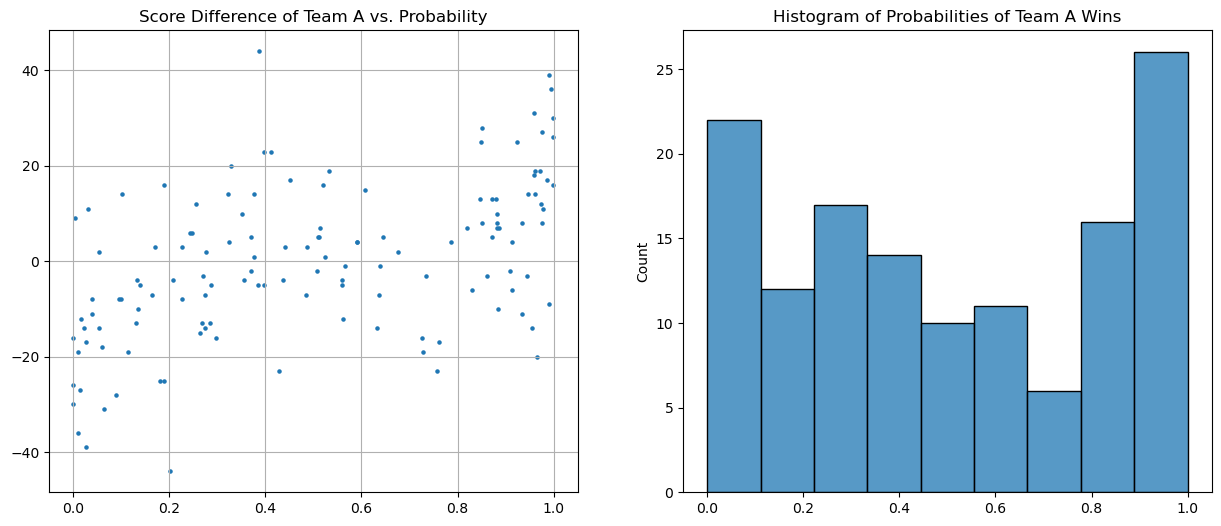

In [22]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Score Difference of Team A vs. Probability')
plt.scatter(y_pred_probs[:,1], df_val['ScoreDiff'].values, s=5)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title('Histogram of Probabilities of Team A Wins')
sns.histplot(y_pred_probs[:,1])
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

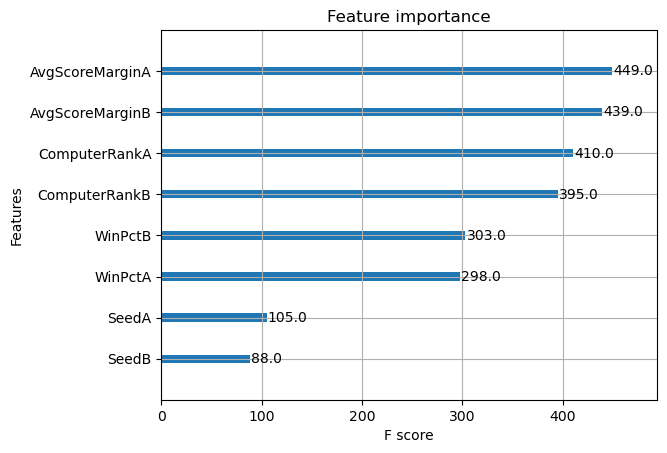

In [23]:
xgb.plot_importance(xgb_clf)

Implement some cross-validation by using different validation sets from years 2016 and after and training on the data before. This returns a list of arrays of predictions for games. You can average or take the best one later to use for actual testing/submission.

In [24]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique() # List of seasons 201
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[12:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].copy()
        df_val = df[df['Season'] == season].copy()
        df_test = df_test_.copy()
        
        
        df_train, df_val, df_test = std_scaler(features, df_train, df_val, df_test)

        model = xgb.XGBClassifier()   
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

Looks like the data match with our pre processing function!

Finally, in order to create a submission, we need to begin assembling the submission which requires the format 'Season_WTeamID_LoseTeamID' and a prediction probability. We'll have to build up the test data with merges the same way we built up the train data.

In [25]:
# Import test data by grabbing the sample submission
test = pd.read_csv(PATH+'SampleSubmissionWarmup.csv')

# Create same features we had above for training data. Split the weird ID formats
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['WTeamID'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['LTeamID'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,WTeamID,LTeamID
0,2017_1101_1102,0.5,2017,1101,1102
1,2017_1101_1103,0.5,2017,1101,1103
2,2017_1101_1104,0.5,2017,1101,1104
3,2017_1101_1105,0.5,2017,1101,1105
4,2017_1101_1106,0.5,2017,1101,1106


In [26]:
test = pd.merge(test, preprocess_data(test, mtourneys, mgames, mseeds, last_rank), 
                left_on=['Season', 'WTeamID', 'LTeamID'],
                right_on=['Season', 'TeamIDA', 'TeamIDB']).drop(['WTeamID', 'LTeamID'], axis=1)
test

,ID,Pred,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,AvgWinMarginA,AvgLossMarginA,WinPctA,AvgScoreMarginA,NumWinsB,NumLossesB,AvgWinMarginB,AvgLossMarginB,WinPctB,AvgScoreMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPctDiff,AvgScoreMarginDiff,ComputerRankDiff
0,2017_1112_1315,0.5,2017,136,1112,100,1315,82,2,15,30.0,4.0,13.700000,10.750000,0.882353,10.823529,19.0,9.0,11.157895,9.888889,0.678571,4.392857,11.706667,149.569444,-13,0.203782,6.430672,-137.862778
1,2017_1112_1388,0.5,2017,138,1112,69,1388,60,2,7,30.0,4.0,13.700000,10.750000,0.882353,10.823529,28.0,4.0,20.035714,16.250000,0.875000,15.500000,11.706667,19.133333,-5,0.007353,-4.676471,-7.426667
2,2017_1112_1462,0.5,2017,143,1112,71,1462,73,2,11,30.0,4.0,13.700000,10.750000,0.882353,10.823529,21.0,13.0,11.952381,10.769231,0.617647,3.264706,11.706667,41.875000,-9,0.264706,7.558824,-30.168333
3,2017_1116_1314,0.5,2017,139,1116,65,1314,72,8,1,25.0,9.0,13.120000,14.555556,0.735294,5.794118,26.0,7.0,19.615385,9.571429,0.787879,13.424242,35.416667,5.426667,7,-0.052585,-7.630125,29.990000
4,2017_1116_1371,0.5,2017,137,1116,77,1371,71,8,9,25.0,9.0,13.120000,14.555556,0.735294,5.794118,21.0,11.0,10.047619,10.090909,0.656250,3.125000,35.416667,44.555556,-1,0.079044,2.669118,-9.138889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2022_1345_1463,0.5,2022,137,1345,78,1463,56,3,14,27.0,7.0,15.703704,7.000000,0.794118,11.029412,18.0,11.0,11.222222,13.000000,0.620690,2.034483,11.621212,138.571429,-11,0.173428,8.994929,-126.950216
330,2022_1371_1395,0.5,2022,137,1371,42,1395,69,8,9,20.0,10.0,11.450000,7.100000,0.666667,5.266667,20.0,12.0,11.200000,10.416667,0.625000,3.093750,36.890625,43.968254,-1,0.041667,2.172917,-7.077629
331,2022_1388_1417,0.5,2022,138,1388,56,1417,72,5,4,24.0,7.0,13.916667,10.714286,0.774194,8.354839,25.0,7.0,16.880000,7.428571,0.781250,11.562500,19.878788,10.393939,1,-0.007056,-3.207661,9.484848
332,2022_1394_1411,0.5,2022,134,1394,67,1411,76,16,16,19.0,11.0,10.000000,9.909091,0.633333,2.700000,18.0,12.0,12.944444,10.083333,0.600000,3.733333,233.142857,200.873016,0,0.033333,-1.033333,32.269841



Validating on season 2015


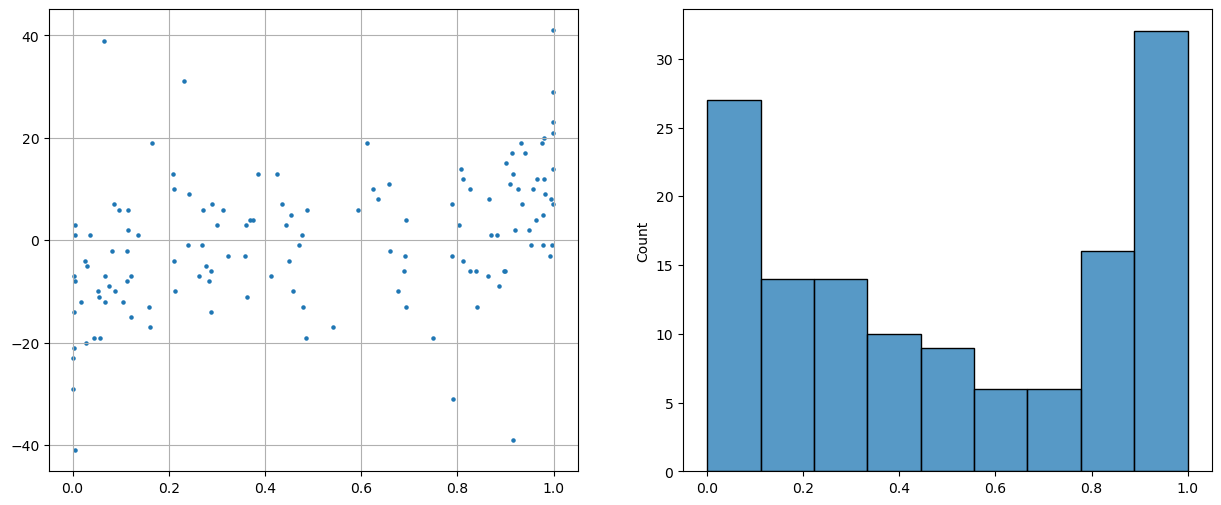

	 -> Scored 0.823

Validating on season 2016


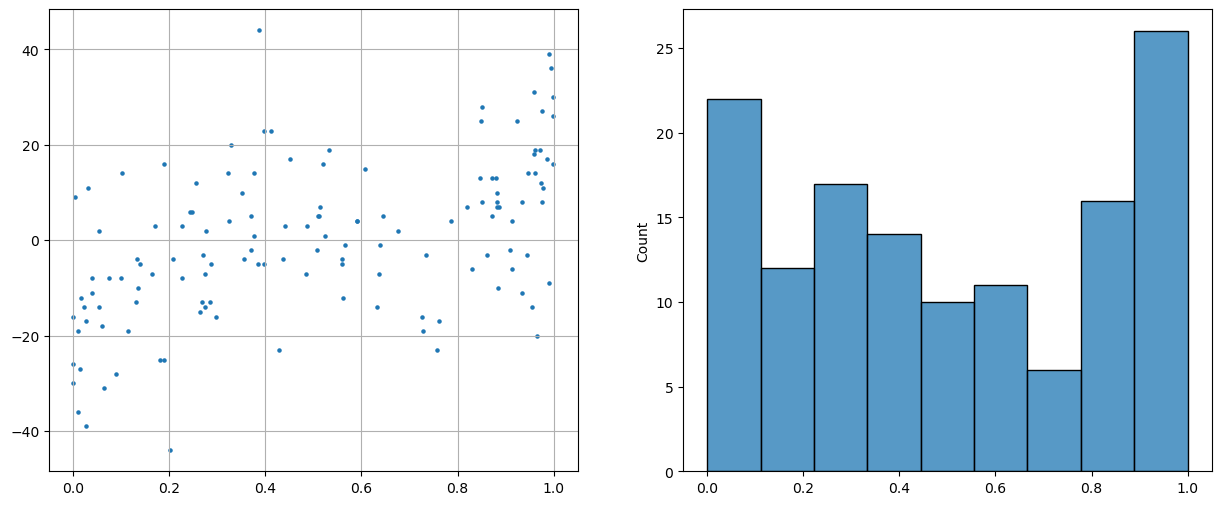

	 -> Scored 0.716

Validating on season 2017


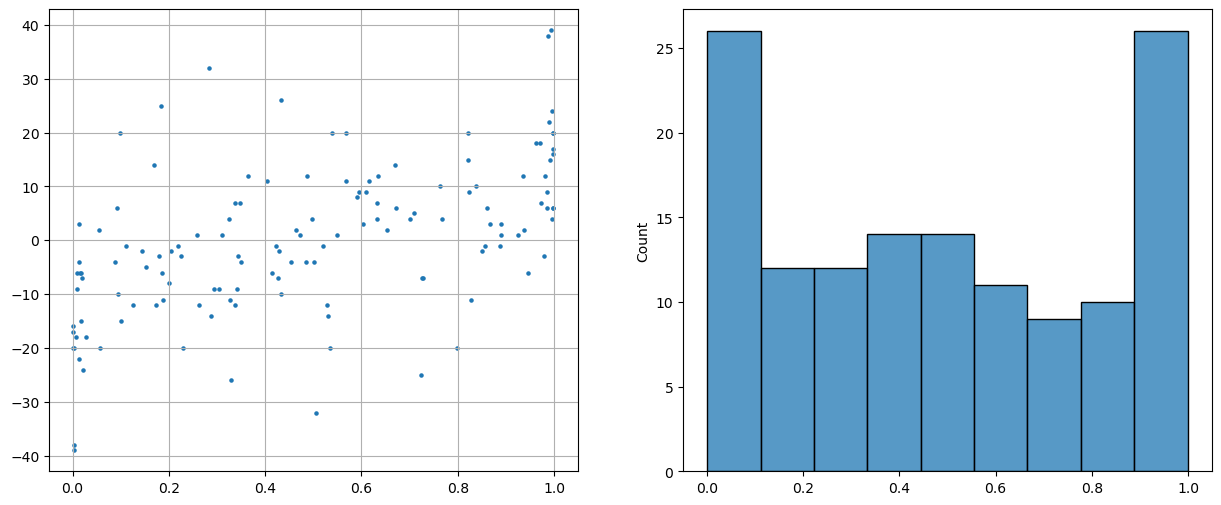

	 -> Scored 0.552

Validating on season 2018


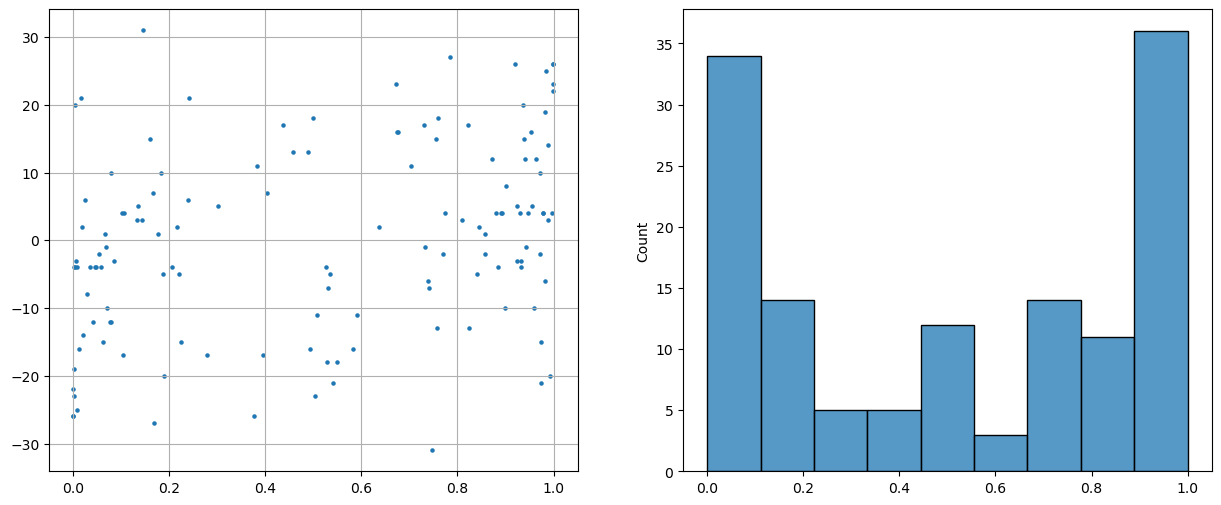

	 -> Scored 0.909

Validating on season 2019


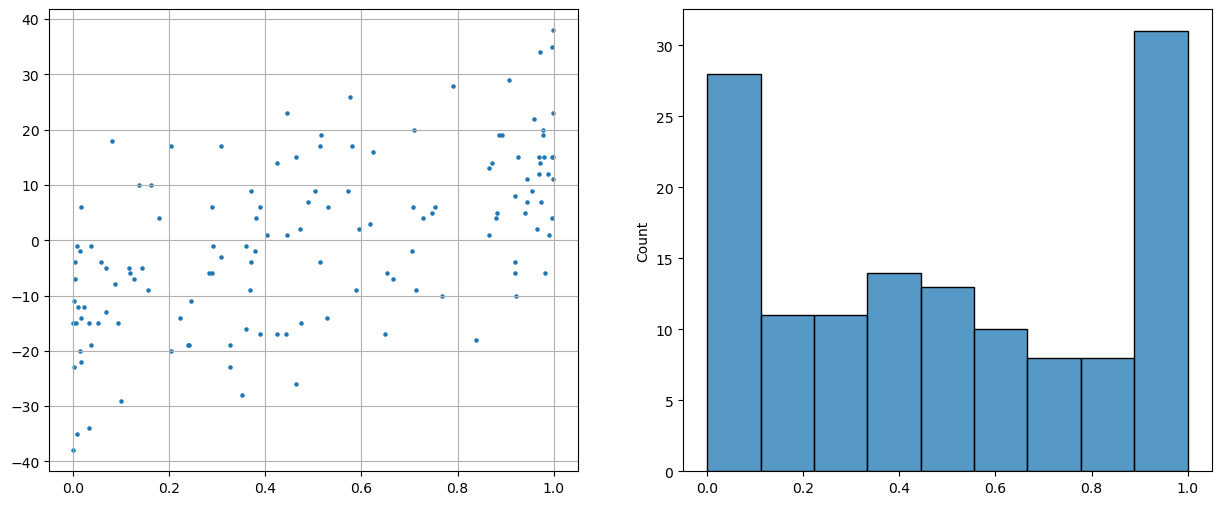

	 -> Scored 0.503

Validating on season 2021


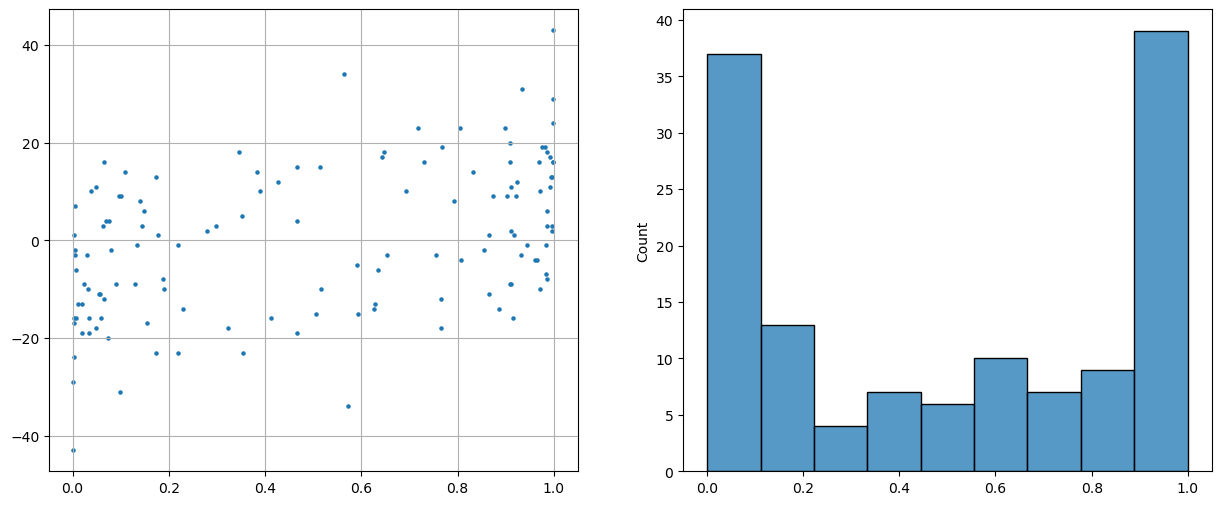

	 -> Scored 0.899

Validating on season 2022


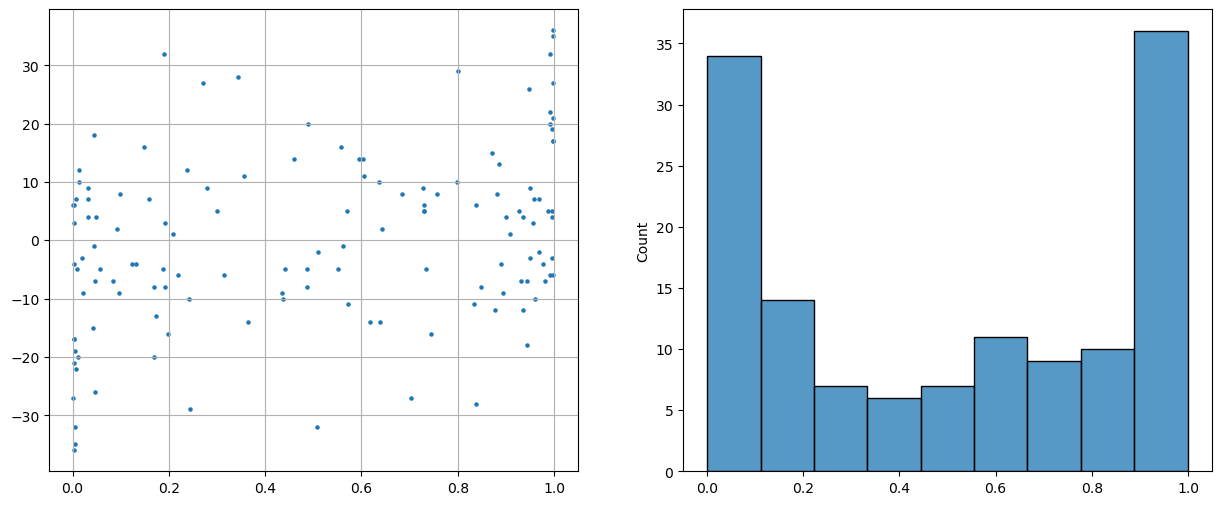

	 -> Scored 1.144

 Local CV is 0.792


In [27]:
pred_tests = kfold_reg(train, test[features], plot=True, verbose=1, mode='cls')

We now have a list of arrays of results of game predictions. Let's average them (or try taking the best classifier) and making test predictions.

In [28]:
# Take the average by averaging over each row in each array in our list of arrays
avg_pred_tests = np.mean(pred_tests, axis=0)
submit = test[['ID', 'Pred']].copy()
submit['Pred'] = avg_pred_tests
submit.to_csv('submission.csv', index=False)